In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import networkx.readwrite.gml as nrg
import warnings
warnings.filterwarnings('ignore')
import random
import sys

#### Função k-means

- Cria um cluster de nós próximos a um centro ( nosso controlador )
- Dentro deste cluster seleciona um nó para ser o novo centro, que chamamos de centróide.
    - O nó que tiver a menor distância para todos os nós do cluster vira esse centróide
    

In [2]:
def revised_k_means(G,cent,cnode,centdis):
    # Baseada em https://github.com/Eiichiro3719/Clustering-Algorithm
    
    # cent = nós de centro de cluster (controladores)
    # cnode = clusterNodes, os nós pertencentes aquele cluster
    
    # copiar
    oldCent = cent[:]
         
    for i in G.nodes():
        G.node[i]['distanceSum']=0      
        G.node[i]['controllerDistance']=sys.maxint
    
    
    
    # step 2 -  select shortest path from centroid to each node
    
    # atribuir cada nó para o cluster i que estiver mais próximo dele
    # inicialmente os nós estão com distância infinita. 
    # Ao longo do loop eles vão convergindo para o cluster com menor distância dada pelo dijkstra_path_length
    for v in G.nodes():  
        for i in range(len(cent)):
            if G.node[v]['controllerDistance'] > nx.dijkstra_path_length(G,v,cent[i]):
                if(v in cnode[G.node[v]['controllerId']]): cnode[G.node[v]['controllerId']].remove(v) ## remove do controlador antigo
                G.node[v]['controllerId']=i
                G.node[v]['controllerDistance']=nx.dijkstra_path_length(G,v,cent[i])  
        # Agora adiciona o nó v ao cluster do controllerId
        cnode[G.node[v]['controllerId']].append(v) 
        
                    
    #step 3 - Update centroid such that the sum of the shortest path distance from all points is minimized
   
    for i in range(len(cent)):
        # test for each node v of the current controller i
        for v in cnode[i]:          
                            
            #  Somo em v, a distancia de v até cada um dos nós do cluster (ao qual ele pertence)
            for j in range(len(cnode[i])):
                G.node[v]['distanceSum']+=nx.dijkstra_path_length(G,v,cnode[i][j])
                            
            # o meu nó v vira meu novo centroide se sua soma da distância de nós for menor que o contróide atual
            if G.node[v]['distanceSum'] < centdis[i]:  
                centdis[i]=G.node[v]['distanceSum']             
                cent[i]=v
       


    ## Repetir até convergir (i.e até que nada mude de uma iteração para outra)
    same = 1
    for i in range(len(oldCent)):
        if(oldCent[i] != cent[i]):
            same = 0
            break
    #print "old",oldCent,"\n new",cent,"\n same?:",same
    if not (same):
        cnode = revised_k_means(G,cent,cnode,centdis)
    
    
    ## print stuff
    
    #for i in G.nodes():
        #if cent.count(i) > 0:
            #print "Controlador",i,"Id:",G.node[i]['controllerId'],"com a soma de distancias:",G.node[i]['distanceSum']
    
    #for i in range(len(cent)):
       # print "Cluster Nº",i,"centroide:",cent[i], "nós:",cnode[i]
        
    return cnode


## Função maxccdist  
Encontra a maior distância entre dois controladores na rede

In [3]:
def maxccdist(G,cent):
    ccdist=-1
    for i in range(len(cent)):
        for j in range(i+1,len(cent)):
            if ccdist < nx.dijkstra_path_length(G,cent[i],cent[j]):
                ccdist=nx.dijkstra_path_length(G,cent[i],cent[j])
                c1 = i
                c2 = j
    #print "Maximum Controller/Controller distance is: ",ccdist,", from:",cent[c1],"to:",cent[c2]
    return ccdist,cent[c1],cent[c2]

## Função maxcsdist
Encontra a distância máxima entre um controlador e um nó pertencente a ele na rede

In [4]:
def maxcsdist(G,cent,cnode):
    csdl=[-1 for i in range(len(cent))] # Csdl is an array of maximum distance nodes to each controller C
    csnodes=[-1 for i in range(len(cent))] # csnodes is an array of nodes that have maximum distance to each controller C
    for i in range(len(cent)):
        for v in G.nodes():
            for j in range(len(cnode[i])):
                if csdl[i] < nx.dijkstra_path_length(G,cent[i],cnode[i][j]):
                    csdl[i]=nx.dijkstra_path_length(G,cent[i],cnode[i][j])
                    csnodes[i] = cnode[i][j]

    
    #print "Max Node delays for each controller:",zip(cent, csdl,csnodes)
    maxPos = csdl.index(max(csdl))
    #print "Maximum Controller/Node delay is:",max(csdl),",from:",cent[maxPos],"to:",csnodes[maxPos]
    return max(csdl),cent[maxPos],csnodes[maxPos]    

## Função para adicionar informações de latência no grafo

Usa a função harversine para calcular a distância entre estes 2 pontos geográficos
Usa a distância para calcular a latência com a formula $latency =  \frac{dist}{2 \times 10^8}$

A latência fica em ms. Para mostrar melhor no grafo a latência é multiplicada por 1000


In [5]:

def add_latency_info(G):
    

    # Haversine formula
    # Essa formula fornece distâncias entre dois pontos de uma esfera a partir de suas latitudes e longitudes.
    # Author: Wayne Dyck

    import math

    def harvesine(origin, destination):
        lat1, lon1 = origin
        lat2, lon2 = destination
        radius = 6371000 # radius of Earth in meters, for meters use 6371000

        dlat = math.radians(lat2-lat1)
        dlon = math.radians(lon2-lon1)
        a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
            * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        d = radius * c

        return d


    ## inicializa latência no grafo G
    for i in G.edges:
        orig,dest = i
        dist = harvesine([G.node[orig]['Latitude'],G.node[orig]['Longitude']],[G.node[dest]['Latitude'],G.node[dest]['Longitude']])
        latency = dist/(2*10**8)
        latency = latency * 1000  # fator de escala só para mostrar melhor no grafo
        latency = round(latency,2)
        G.edges[i]['weight'] = latency
        #print "dist from",orig,"to",dest,"is",dist, "with latency",latency


    #exemplo no OS3E
    #G.edges['Baton_Rouge', u'Houston'] 

## Função de plotagem do grafo da topologia
Mostra controladores como pontos brancos com borda colorida
Mostra nós como pontos coloridos
A cor denota um cluster

Entre nós também é mostrado o delay (em ms) como custo do caminho.

In [185]:
def plot_network(y_off=0.5,x_off=1,x_size=10,y_size=11):
    
    #  Transformar a latitude e longitude em uma tupla de posições para serem exibidas no plot

    lat=nx.get_node_attributes(G,'Latitude')
    lng=nx.get_node_attributes(G,'Longitude')

    
    # merging dicts for each key
    #https://stackoverflow.com/questions/5946236/how-to-merge-multiple-dicts-with-same-key
    from collections import defaultdict
    pos = defaultdict(list)

    for d in (lng, lat): # you can list as many input dicts as you want here
        for key, value in d.items():
            pos[key].append(value)

            
    # salva uma lista de pesos de arestas para poder usar no plot
    edge_labels = dict([((u,v,), d['weight']) for u,v,d in G.edges(data=True)])
    
    # acha o nó de maxima distância
    maxCS,fromCS,toCS=maxcsdist(G,cent,cnode) ## maximum distance from controller to node inside it's subnetwork
    
    #maxCC,fromCC,toCC=maxccdist(G,cent) ## maximum distance from controller to controller

 
    # offset on the y axis of the nodes position

    pos_higher = {}

    for k, v in pos.items():
        pos_higher[k] = (v[0]+x_off, v[1]+y_off)

    plt.figure(3,figsize=(x_size,y_size))  ## tamanho da imagem
    nx.draw(G,pos,node_size=120,with_labels=False)
    #nx.draw_networkx_labels(G, pos_higher,font_size=8,alpha=0.8)


    colors=["r","g","b","c","m","y","C0","C1","C2","C3","C4","C5","C6","C7","C8","C9"]


    for i in range(len(cnode)):
        nx.draw_networkx_nodes(G,pos,cnode[i],node_size=120,node_color=colors[i])
        #print cnode[i]

    nx.draw_networkx_nodes(G,pos,cent,node_size=80,node_color='white',alpha=1)
    nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels,font_size=8)


    ## draw paths

    # Controller to Controller
    #CCpath = nx.dijkstra_path(G,source=fromCC,target=toCC)
    #CCpath = zip(CCpath,CCpath[1:])
    #nx.draw_networkx_edges(G,pos,edgelist=CCpath,edge_color='r',width=8)

    #Controller to node
    CSpath = nx.dijkstra_path(G,source=fromCS,target=toCS)
    CSpath = zip(CSpath,CSpath[1:])
    nx.draw_networkx_edges(G,pos,edgelist=CSpath,edge_color='b',width=5)

    print "K = ",len(cent)
    print "Nós controladores:",cent
    print "Distância máxima de controlador para roteador:", maxCS
    #print "max controller to controller distance:", maxCC
    plt.savefig('out.pdf')
    plt.show()
    return maxCS

# Inicio

### Carregar um grafo e definir a quantiade de partições ou o delay

In [189]:
G=nrg.read_gml("graphdata/chinanet.gml") 
# chinanet.gml Rnp.gml  OS3E.gml Litnet.gml Biznet.gml Evolink Forthnet GtsCzechRepublic GtsPoland Aarnet

C=6
max_delay=6  ## 6 ms

### Remover nós internacionais, adicionar informações de latência e outras informações de controle

In [190]:
try:
    #to_del = [n for n in G if G.node[n]['Internal'] == 0 ]
    to_del = [n for n in G if not 'Latitude' in G.node[n]]
    G.remove_nodes_from(to_del)
except:
    print("Erro ao remover nós internacionais. Pode ser que não existam")

In [191]:
add_latency_info(G)

In [192]:
for i in G.nodes:
    G.node[str(i)]['center']=False
    G.node[str(i)]['controllerId']=-1
    G.node[str(i)]['distanceSum']=0
    G.node[str(i)]['controllerDistance']=sys.maxint

# Algoritmo

K =  1
Nós controladores: [u'Beijing']
Distância máxima de controlador para roteador: 18.31


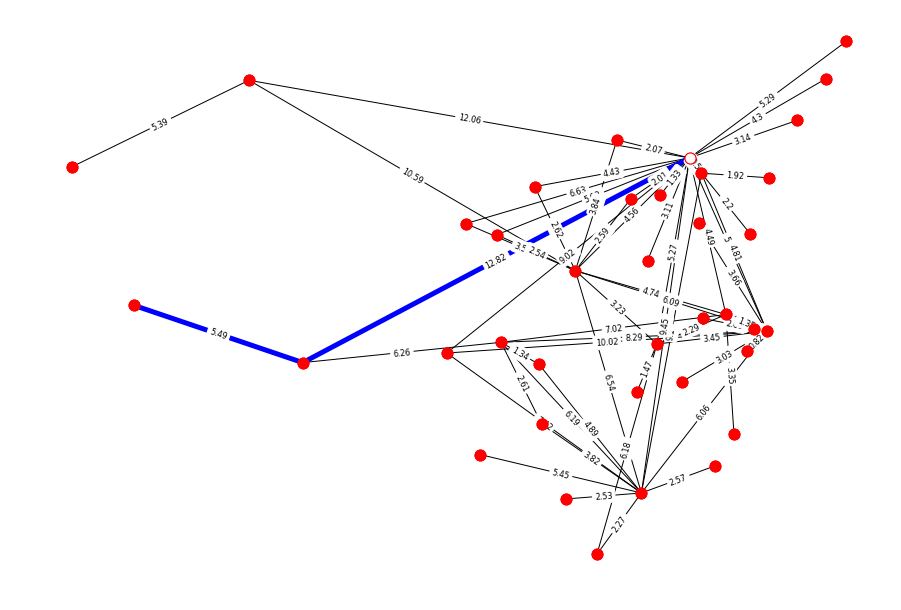

18.310000000000002

In [193]:

# step 2, select one node as the center

cent = []
cent=random.sample(G.nodes(),1)

# centdis = para cada cluster, a distancia total dos nós até o centro (seu controlador)
centdis = []
#---------------------initialize the new distance to the center
for i in range(len(cent)): 
    centdis.append(sys.maxint)
    
# step 3, do the k-means to find the first centroid
cnode=[[] for i in range(1)]
cnode = revised_k_means(G,cent,cnode,centdis)
cent
plot_network(x_size=12,y_size=8)


K =  2
Nós controladores: [u'Beijing', u'Lhasa']
Distância máxima de controlador para roteador: 17.45


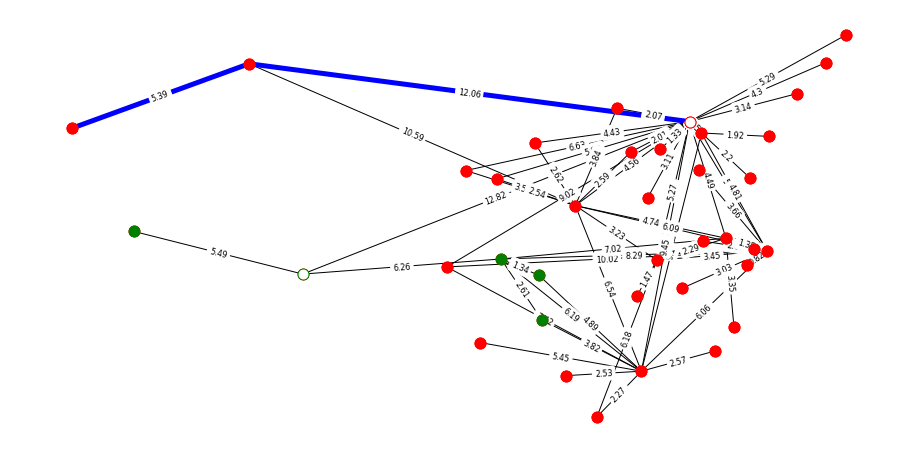

K =  3
Nós controladores: [u'Beijing', u'Chengdu', u'Urumqi']
Distância máxima de controlador para roteador: 11.75


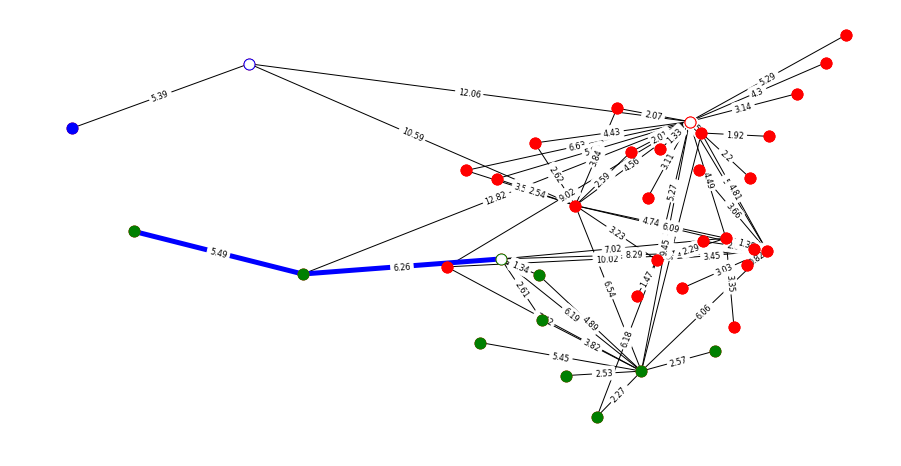

end


In [194]:
new_maxCS = sys.maxint
h = 0
    
#while h < C-1:  ## rodmax_delaya k partições
while new_maxCS > max_delay:  ## vai particionando até masCS chegar ao limiar
    # step 4, find the most distant node and assign as a new center
    maxCS,fromCS,toCS=maxcsdist(G,cent,cnode)
    
    # step 5, assign the most distant node is a new center.
    cent.append(toCS)
        
    # step 6, redo the k-means with the new centers and update centroids
    

    cnode=[[] for i in range(len(cent))]
    
    # centdis = para cada cluster, a distancia total dos nós até o centro (seu controlador)
    centdis = []
    #---------------------initialize the new distance to the center
    for i in range(len(cent)): 
        centdis.append(sys.maxint)
    
    cnode = revised_k_means(G,cent,cnode,centdis)
    new_maxCS,_,_=maxcsdist(G,cent,cnode)


    h+=1
    plot_network(x_size=12,y_size=6)
print "end"

### Teste com o k-means original

In [13]:
maxcs = 0
# try the original k-means 100 times
for i in xrange(20):
    cent = []
    cent=random.sample(G.nodes(),C)

    centdis = []
    for i in range(len(cent)): 
        centdis.append(sys.maxint)

    cnode=[[] for i in range(C)]
    cnode = revised_k_means(G,cent,cnode,centdis)
    k,_,_= maxcsdist(G,cent,cnode)
    maxcs += k

print maxcs / 20


IndexError: list index out of range